## Section 1: Business Understanding

The goal of this project is to analyze the data from the 2020 Stack Overflow survey. More specifically, I am going to focus on  answering the following questions:

- What have been the most used programming languages in 2020?

- How does the salary vary depending on the type of developer?

- How does job satisfaction vary depending on the type of developer?

## Section 2: Data Uderstanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import matplotlib.ticker as mtick

### Gather

In [2]:
stack = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')

### Assess

In [3]:
stack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

In [4]:
def get_description_and_unique (col_name, schema = schema):
    
    '''
    Gives the description of a column and its unique values
    '''

    description = list(schema[schema['Column'] == col_name]['QuestionText'])[0]
    unique_values = stack[col_name].unique()
    return description, unique_values

In [5]:
get_description_and_unique('LanguageWorkedWith')

('Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)',
 array(['C#;HTML/CSS;JavaScript', 'JavaScript;Swift',
        'Objective-C;Python;Swift', ...,
        'Bash/Shell/PowerShell;C;C++;Go;HTML/CSS;JavaScript;Kotlin;Python;Ruby;Rust;SQL',
        'Bash/Shell/PowerShell;C#;C++;HTML/CSS;JavaScript;Kotlin;PHP;SQL;VBA',
        'Bash/Shell/PowerShell;C;C#;C++;HTML/CSS;Java;JavaScript;Objective-C;Python;Swift'],
       dtype=object))

In [6]:
#Chosen variables
df = stack[['Country', 'ConvertedComp', 'DevType', 'JobSat', 'LanguageWorkedWith']]

#Check duplicates
sum(df.duplicated())

6832

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             64072 non-null  object 
 1   ConvertedComp       34756 non-null  float64
 2   DevType             49370 non-null  object 
 3   JobSat              45194 non-null  object 
 4   LanguageWorkedWith  57378 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.5+ MB


In [8]:
df.head()

,Country,ConvertedComp,DevType,JobSat,LanguageWorkedWith
0,Germany,NaN,"Developer, desktop or enterprise applications;...",Slightly satisfied,C#;HTML/CSS;JavaScript
1,United Kingdom,NaN,"Developer, full-stack;Developer, mobile",Very dissatisfied,JavaScript;Swift
2,Russian Federation,NaN,NaN,NaN,Objective-C;Python;Swift
3,Albania,NaN,NaN,Slightly dissatisfied,NaN
4,United States,NaN,NaN,NaN,HTML/CSS;Ruby;SQL


## Section 3: Data Preparation

In [9]:
#Drop duplicates
df = df.drop_duplicates()

In [10]:
def dummy_array(df, col_list):
    '''
    The columns in col_list must have each observation as an array with the elements separated by ';' 
    Creates dummy columns for each variable in col_list
    Removes the original columns
    Chooses if create a variable for the Nan values in dummy_na
    '''

    #Create a dummy variable for each language or devtype
    for item in col_list:
        split = df[item].str.strip('[]').str.split('\s*;')
        dummy = (split.explode().str.get_dummies().sum(level=0).add_prefix(item + '_'))
        df = df.drop([item], 1).join([dummy])
    
    return df

In [11]:
def split_survey_string (dataset, col_name, sep_type):
    '''
    It gets a column with an array-like value. 
    Separates all the single values in the array and appends it to a list iterating trough all the rows in the dataset
    '''
    
    
    #Order values by count, rename columns and split strings
    temp = dataset[col_name].value_counts().reset_index()
    temp.rename(columns = {'index': 'method', col_name:'count'}, inplace = True)
    temp['method'] = temp['method'].str.split(sep_type)
    
    #Create a list with all separated values
    val_list = []
    for i in range(temp.shape[0]):
        for j in temp['method'][i]:
            val_list.append(j)
    
    #Convert list to series
    series = pd.Series(val_list)
    
    return series

In [12]:
#Create a percentage of the frequency that a programming language is used
language_split = split_survey_string (df, 'LanguageWorkedWith', ';')
ratio = (language_split.value_counts()/df.shape[0])

In [13]:
#Create a of unique values for the DevType column
split = split_survey_string(df, 'DevType', ';')
list_unique = split.unique()

In [14]:
#Dummy and remove the DevType column
df = dummy_array(df, ['DevType'])
df

,Country,ConvertedComp,JobSat,LanguageWorkedWith,DevType_Academic researcher,DevType_Data or business analyst,DevType_Data scientist or machine learning specialist,DevType_Database administrator,DevType_Designer,DevType_DevOps specialist,...,"DevType_Developer, mobile",DevType_Educator,"DevType_Engineer, data","DevType_Engineer, site reliability",DevType_Engineering manager,DevType_Marketing or sales professional,DevType_Product manager,DevType_Scientist,DevType_Senior executive/VP,DevType_System administrator
0,Germany,NaN,Slightly satisfied,C#;HTML/CSS;JavaScript,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,United Kingdom,NaN,Very dissatisfied,JavaScript;Swift,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Russian Federation,NaN,NaN,Objective-C;Python;Swift,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albania,NaN,Slightly dissatisfied,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,United States,NaN,NaN,HTML/CSS;Ruby;SQL,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64449,Saudi Arabia,NaN,NaN,NaN,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
64451,Poland,NaN,NaN,NaN,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64453,Thailand,NaN,NaN,C++;HTML/CSS,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
64457,Morocco,NaN,NaN,Assembly;Bash/Shell/PowerShell;C;C#;C++;Dart;G...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Creates a new dataset with the enhaced DevType column
appended_data = []
list_columns = []
for item in list_unique:
    col_name = 'DevType_' + item
    data = df[df[col_name] == 1]
    data['DevType'] = item
    appended_data.append(data)
    list_columns.append(col_name)
    
appended_data = pd.concat(appended_data)
df_clean = appended_data[['Country', 'ConvertedComp', 'DevType', 'JobSat']]

<ipython-input-15-3e69930e6b74>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DevType'] = item
<ipython-input-15-3e69930e6b74>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DevType'] = item
<ipython-input-15-3e69930e6b74>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [16]:
#Removes some positions that are more related with promotions than with developer type
not_var = ['Engineering manager',   'Scientist', 'Senior executive/VP', 'Product manager', 'Educator',
       'Engineer, site reliability', 'Marketing or sales professional']

for i in range(len(not_var)):
    var = not_var[i]
    df_clean = df_clean[df_clean['DevType'] != var]

In [17]:
#Rename the developer types
rename_map = {'Developer, full-stack': 'Full-stack developer', 'Developer, back-end': 'Back-end developer',
               'Developer, front-end': 'Front-end developer', 'Developer, mobile': 'Mobile developer',
               'Developer, desktop or enterprise applications': 'Desktop developer',
               'Developer, embedded applications or devices': 'Embedded developer',
               'Data scientist or machine learning specialist': 'Data scientist',
               'Developer, QA or test': 'QA or test developer', 'Data or business analyst': 'Data analyst',
               'Engineer, data':'Data engineer', 'Developer, game or graphics': 'Game or graphics developer'}

df_clean['DevType'] = df_clean['DevType'].replace(rename_map)


In [18]:
#Change Jobsat dtype to float
scale_mapper = {'Very dissatisfied':1, 'Slightly dissatisfied':2, 'Neither satisfied nor dissatisfied':3,
               'Slightly satisfied':4, 'Very satisfied':5}
df_clean['JobSat'] = df_clean['JobSat'].replace(scale_mapper)

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142058 entries, 0 to 64446
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Country        142058 non-null  object 
 1   ConvertedComp  99703 non-null   float64
 2   DevType        142058 non-null  object 
 3   JobSat         128950 non-null  float64
dtypes: float64(2), object(2)
memory usage: 5.4+ MB


In [20]:
df_clean.head()

,Country,ConvertedComp,DevType,JobSat
0,Germany,NaN,Full-stack developer,4.0
1,United Kingdom,NaN,Full-stack developer,1.0
8,Tunisia,NaN,Full-stack developer,1.0
9,United Kingdom,32315.0,Full-stack developer,5.0
15,United Kingdom,108576.0,Full-stack developer,5.0


## Section 4: Evaluation

### Question 1: What have been the most used programming languages in 2020?

In [21]:
#Plot top programming languages
def print_percentage_top(series, top_num, title):
    
    temp = series.head(top_num)
    
    plt.figure(figsize = [11.69, 8.27])
    base_color = 'cornflowerblue'
    ax = sb.barplot(temp.index, temp.values, color = base_color)
    plt.title(title, fontsize = 18, loc = 'left', pad = 20)
    

    #Remove plot frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #Draw y grid below the bars
    ax.set_axisbelow(True)
    ax.grid(axis='y')

    #Introducte percentages
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate( f'{height:.1%}', (x + width/2, y + height*1.02), ha='center')

    return ax

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


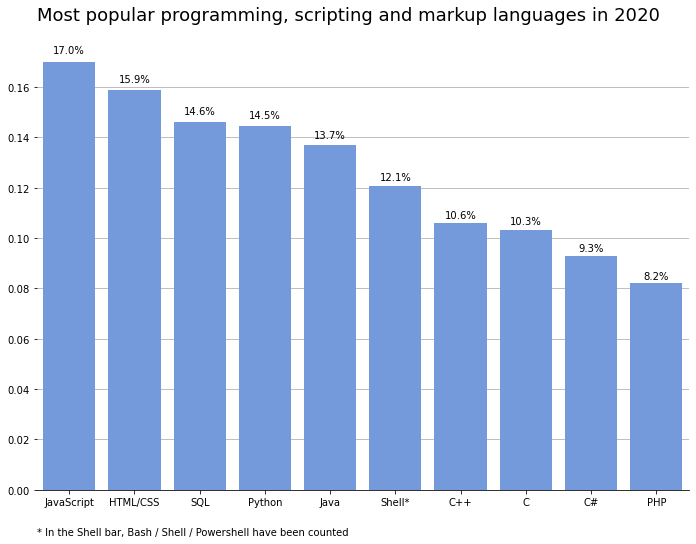

In [22]:
#Plot top 10 programming languages in 2020
ax = print_percentage_top(ratio, 10, 'Most popular programming, scripting and markup languages in 2020')
#Change the 5th label to fit properly in the plot
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[5] = 'Shell*'
ax.set_xticklabels(labels)
ax.set_xlabel('* In the Shell bar, Bash / Shell / Powershell have been counted', loc = 'left', labelpad = 20)

plt.show()

### Question 2: How does the salary vary depending on the type of developer?

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


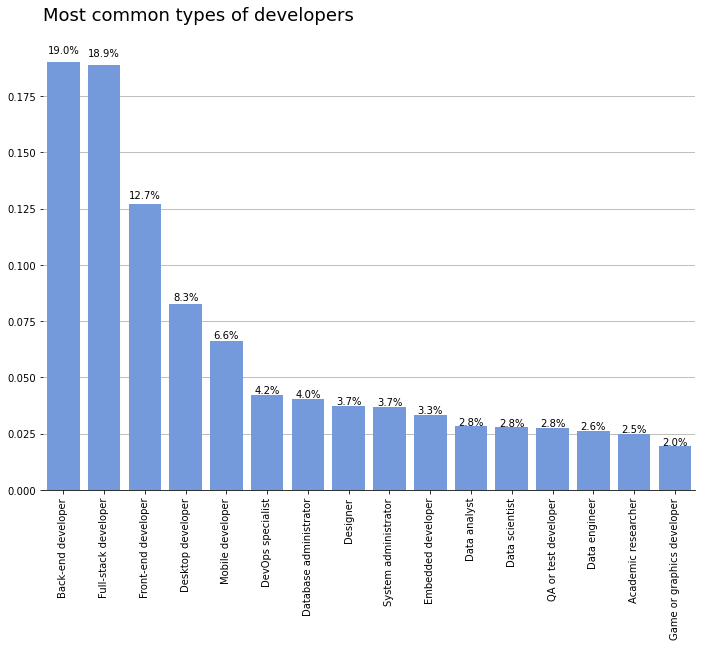

In [23]:
#Distribution of types of developers
ratio2 = (df_clean.DevType.value_counts()/df_clean.shape[0])

ax = print_percentage_top(ratio2, 25, 'Most common types of developers')
plt.xticks(rotation='vertical')
plt.show()

In [24]:
def customPlot(country, response, row, col, color):
    
    '''
    It creates a grid plot of 2x2 differenciating by countries and showing the median of each type of developer if 
    the response is the salary, or else, it shows the mean.
    '''
    
    temp = df_clean[df_clean['Country'] == country]
    
    if response == 'ConvertedComp':
        temp_flat = temp.groupby(['DevType']).median()[response].sort_values(ascending = True)
        
    else: 
        temp_flat = temp.groupby(['DevType']).mean()[response].sort_values(ascending = True)

    x = temp_flat
    y = temp_flat.index
    
    #Plot and title
    ax[row, col].barh(y, x, color=color)
    ax[row, col].set_title(country, loc = 'left', fontsize = 18, pad = 20)

    #Remove plot frame
    ax[row, col].spines['top'].set_visible(False)
    ax[row, col].spines['right'].set_visible(False)
    ax[row, col].spines['left'].set_visible(False)
    ax[row, col].spines['bottom'].set_visible(False)

    #Draw y grid below the bars
    ax[row, col].set_axisbelow(True)
    ax[row, col].grid(axis='x')
    
    #Xticks location ConvertedComp
    if response == 'ConvertedComp':
        
        if temp_flat.max() > 100000:
            ax[row, col].set_xticks(np.arange(0, temp_flat.max(), 30000))

        elif temp_flat.max() > 55000 and temp_flat.max() < 100000:
            ax[row, col].set_xticks(np.arange(0, temp_flat.max(), 20000))

        elif temp_flat.max() > 30000 and temp_flat.max() < 55000:
            ax[row, col].set_xticks(np.arange(0, temp_flat.max(), 15000))

        else:
            ax[row, col].set_xticks(np.arange(0, temp_flat.max(), 5000))
    else:
        pass


    #Introduce dollar symbol
    if response == 'ConvertedComp':
        
        fmt = '${x:,.0f}'
        tick = mtick.StrMethodFormatter(fmt)
        ax[row, col].xaxis.set_major_formatter(tick)
        
    else:
        pass

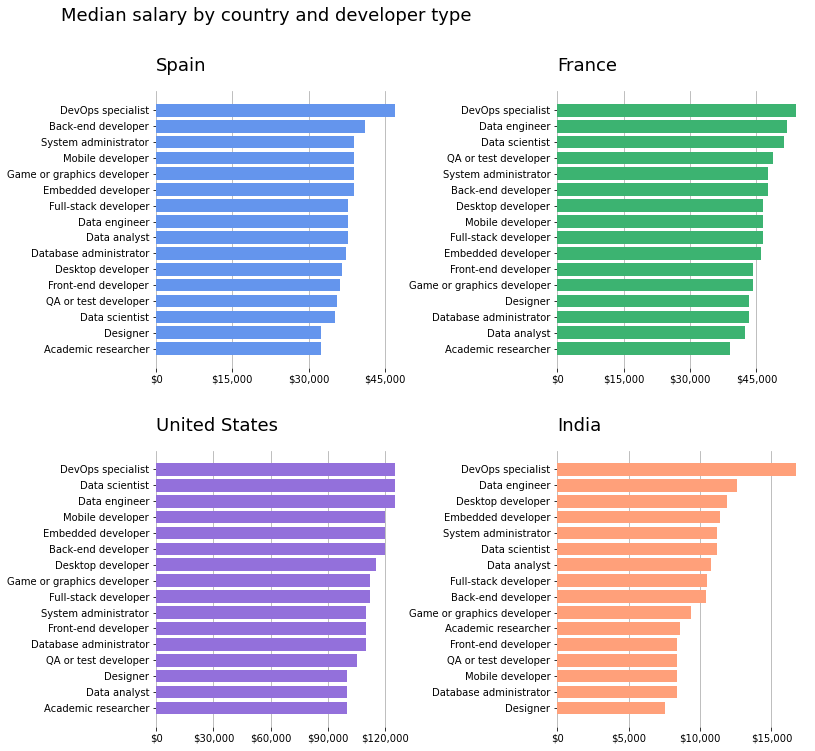

In [25]:
#Plot: Median Salary by country plot
fig, ax = plt.subplots(2, 2)
fig.set_figheight(11.69)
fig.set_figwidth(11.69)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace= 0.3)

fig.suptitle('Median salary by country and developer type', ha = 'right', fontsize = 18)

customPlot('Spain', 'ConvertedComp', 0, 0, 'cornflowerblue')
customPlot('France', 'ConvertedComp', 0, 1, 'mediumseagreen')
customPlot('United States', 'ConvertedComp', 1, 0, 'mediumpurple')
customPlot('India', 'ConvertedComp', 1, 1, 'lightsalmon')

plt.show()

In [26]:
#General median salary in United States
df_clean[df_clean['Country'] == 'United States']['ConvertedComp'].median()

115000.0

### Question 3: How does job satisfaction vary depending on the type of developer?

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


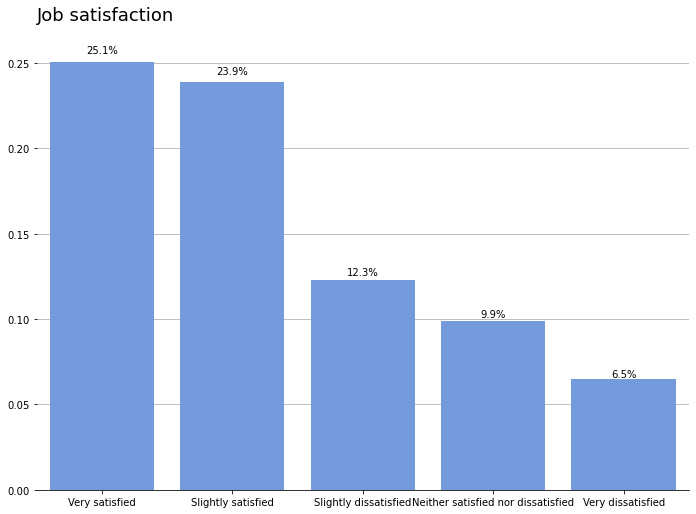

In [27]:
#Distribution of job satisfaction
ratio1 = (df.JobSat.value_counts()/df.JobSat.shape[0])
ax1 = print_percentage_top(ratio1, 6, title = 'Job satisfaction')
plt.show()

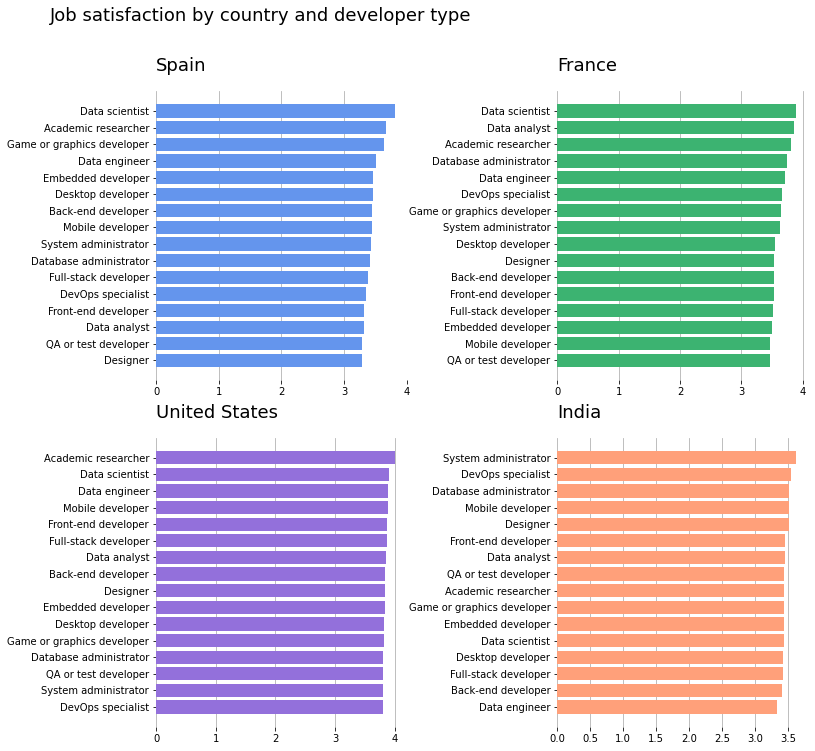

In [28]:
#Plot: Job satisfaction by country and developer type
fig, ax = plt.subplots(2, 2)
fig.set_figheight(11.69)
fig.set_figwidth(11.69)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace= 0.2)

fig.suptitle('Job satisfaction by country and developer type', ha = 'right', fontsize = 18)


customPlot('Spain','JobSat', 0, 0, 'cornflowerblue')
customPlot('France','JobSat', 0, 1, 'mediumseagreen')
customPlot('United States','JobSat', 1, 0, 'mediumpurple')
customPlot('India','JobSat', 1, 1, 'lightsalmon')


plt.show()

C:\Users\rvile\anaconda3\envs\blogpost\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


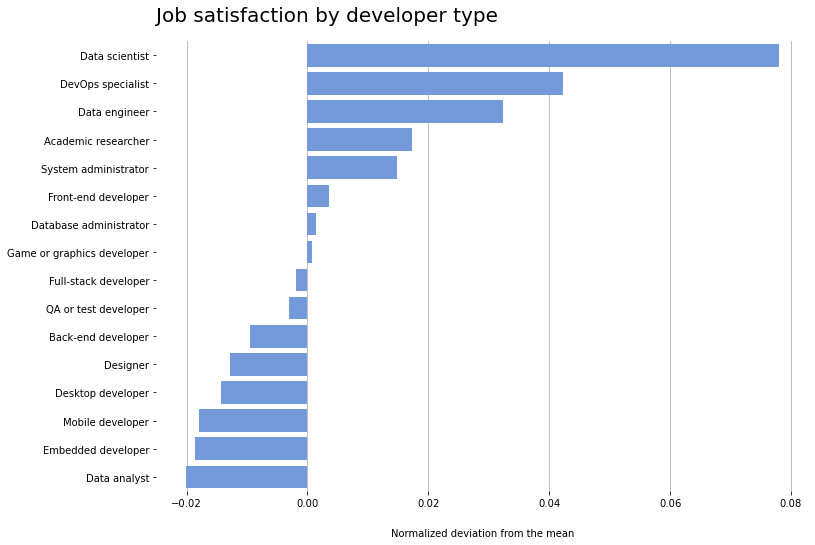

In [29]:
#Plot: Job satisfaction by developer type
temp_flat = df_clean.groupby(['DevType']).mean()['JobSat'].sort_values(ascending = False)

fig = plt.figure(figsize = [11.69, 8.27])
ax = fig.add_axes([.125, .125, .775, .755])

x = (temp_flat - df_clean['JobSat'].mean())/df_clean['JobSat'].std()
y = temp_flat.index

sb.barplot(x, y, color = 'cornflowerblue', errwidth = 0, ax = ax).set(xlabel = None, ylabel = None)

plt.title('Job satisfaction by developer type', loc = 'left', fontsize = 20, pad = 20)
ax.set_xlabel('Normalized deviation from the mean', labelpad = 20)


#Remove plot frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Draw y grid below the bars
ax.set_axisbelow(True)
ax.grid(axis='x')

plt.show()

In [30]:
#General job satisfaction
df_clean['JobSat'].mean()

3.6281349360217137

In [31]:
#Standad deviation of job satisfaction
df_clean['JobSat'].std()

1.3065469810550137